In [1]:
CORPUS_DIR = "longreddit_construction/long-reddit-corpus"
# CORPUS_DIR = "reddit-corpus-small"
# CORPUS_DIR =
DATA_DIR = "data_from2"
PLOT_DIR = "html/graphs_from2"
# hyperconv_range = range(0, 9+1)
hyperconv_range = range(3, 20+1)
rank_range = range(9, 9+1)
max_rank = max(rank_range)
anomaly_threshold = 1.5

In [2]:
import os
os.chdir('../..')
import convokit

In [3]:
os.chdir('convokit/tensors')

In [4]:
from convokit import Corpus, HyperConvo
import pickle
import numpy as np

from tensorly.decomposition import parafac
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

In [5]:
def get_anomalous_points(factor_full, idx):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

In [6]:
def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'hg_features.p'), 'rb') as f:
        hg_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)

    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features


#         factor_to_details[idx]['pos_features'] = get_graphic_dict(idx_to_distinctive_features[idx]['pos_features'][:10])
#         factor_to_details[idx]['neg_features'] = get_graphic_dict(idx_to_distinctive_features[idx]['neg_features'][:10])

    return idx_to_distinctive_threads, idx_to_distinctive_features


In [7]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [8]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 1752
Number of neg threads: 1833
Positive feats: [ 0  7 13 27 37 51 67]
Negative feats: []

Factor 2
Number of pos threads: 2070
Number of neg threads: 1669
Positive feats: [ 12  61  82 131]
Negative feats: [ 0 13 37 67]

Factor 3
Number of pos threads: 1386
Number of neg threads: 1562
Positive feats: [ 63  70  83 107 137]
Negative feats: [ 12  61  67  82 131]

Factor 4
Number of pos threads: 899
Number of neg threads: 2506
Positive feats: [ 37  67 137]
Negative feats: [ 14  20  38  44  63  90 114 133]

Factor 5
Number of pos threads: 785
Number of neg threads: 2296
Positive feats: []
Negative feats: [  4  20  21  44  74  90  91 114 115]

Factor 6
Number of pos threads: 1788
Number of neg threads: 2099
Positive feats: [ 20  44  90 114]
Negative feats: [  4  21  67  71  85 137]

Factor 7
Number of pos threads: 2055
Number of neg threads: 1691
Positive feats: [ 4 21]
Negative feats: [ 63  67  69 137 139]

Factor 8
Number of pos threads: 826
Number of neg t

In [9]:
with open(os.path.join(DATA_DIR, 'tensor.p'), 'rb') as f:
    tensor = pickle.load(f)

## Verify that the trends match

In [10]:
def plot_trend(factor_idx):
    plt.figure(dpi=200, figsize=(9, 6))
    pos_threads = idx_to_distinctive_threads[factor_idx]['pos_threads']
    neg_threads = idx_to_distinctive_threads[factor_idx]['neg_threads']

    pos_feats = idx_to_distinctive_features[factor_idx]['pos_features']
    neg_feats = idx_to_distinctive_features[factor_idx]['neg_features']
    
    pos_pos = tensor[:, pos_threads][:, :, pos_feats].sum(axis=1)
    pos_neg = tensor[:, pos_threads][:, :, neg_feats].sum(axis=1)
    neg_neg = tensor[:, neg_threads][:, :, neg_feats].sum(axis=1)
    neg_pos = tensor[:, neg_threads][:, :, pos_feats].sum(axis=1)
            
    fig, axs = plt.subplots(2, 2)
    
    sign_to_tensor_subset = {
        ('pos', 'pos'): pos_pos,
        ('pos', 'neg'): pos_neg,
        ('neg', 'neg'): neg_neg,
        ('neg', 'pos'): neg_pos
    }
    
    for idx, ((sign1, sign2), tensor_) in enumerate(sign_to_tensor_subset.items()):
        try:
            axs[idx//2][idx % 2].plot(tensor_)
            axs[idx//2][idx % 2].set_title("{} threads, {} features, factor {}".format(sign1, sign2, factor_idx+1))
        except ZeroDivisionError:
            pass
    
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

In [11]:
list(idx_to_distinctive_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [12]:
list(idx_to_distinctive_threads)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

<Figure size 1800x1200 with 0 Axes>

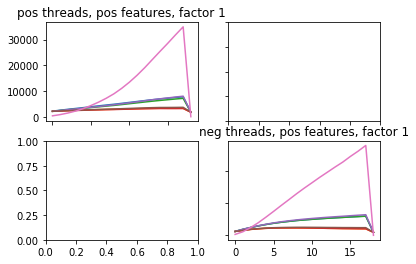

<Figure size 1800x1200 with 0 Axes>

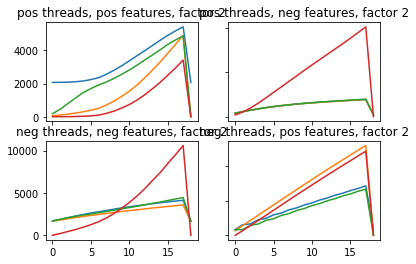

<Figure size 1800x1200 with 0 Axes>

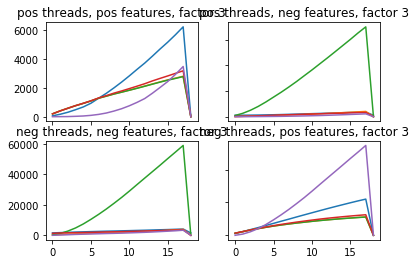

<Figure size 1800x1200 with 0 Axes>

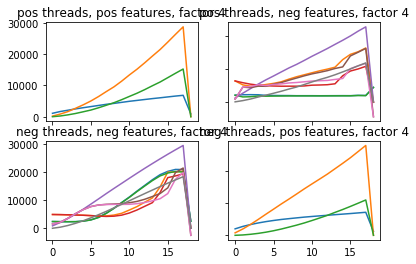

<Figure size 1800x1200 with 0 Axes>

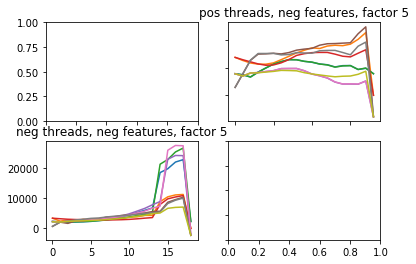

<Figure size 1800x1200 with 0 Axes>

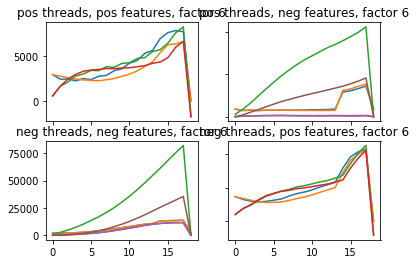

<Figure size 1800x1200 with 0 Axes>

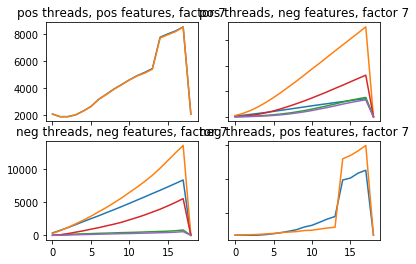

<Figure size 1800x1200 with 0 Axes>

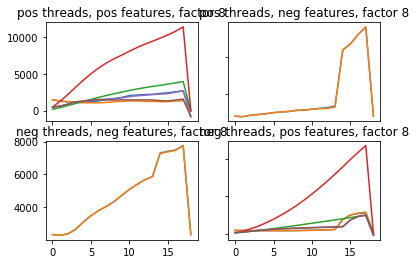

<Figure size 1800x1200 with 0 Axes>

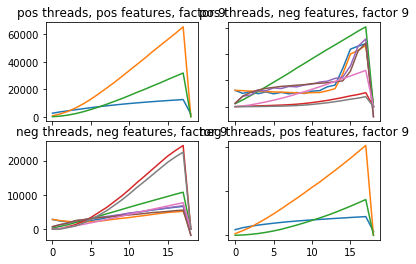

In [13]:
for i in range(max_rank):
    plot_trend(i)

In [15]:
tensor.shape

(19, 29487, 140)

In [16]:
tensor[-1]

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])